In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binom, beta, gamma, poisson, norm, expon, uniform

In [25]:
import BetaBinomial

## Exercise 8.6

In [7]:
beta.ppf([.025,.975],18,92)

/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


array([0.10090844, 0.23792856])

In [6]:
# a)
beta.ppf([.025, .975],4,5) 

/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


array([0.15701277, 0.75513678])

In [8]:
#b) 
beta.ppf([.2, .8],4,5) 

array([0.30322584, 0.58365536])

In [9]:
#c) 
gamma.ppf([.025, .975], 1, scale = 1/8)

array([0.00316473, 0.46110993])

## Excercise 8.8

In [12]:
middleCI = gamma.ppf([.025, .975], 1, scale = 1/5.)
middleCI

array([0.00506356, 0.73777589])

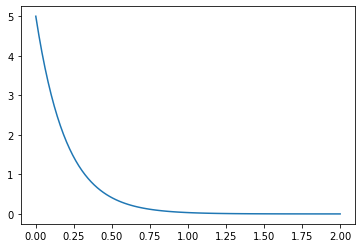

In [15]:
x = np.linspace(0.0, 2, 100)
plt.plot(x, gamma.pdf(x, 1 , scale = 1/5))

From this plot it is obvious that the HDI is just 0 to whatever value gives us 95% , which is very close to 0.6

In [16]:
gamma.ppf(0.95, 1, scale = 1/5.)

0.599146454710798

These areas are different and it seems due to the extreme assymetry that the HDI is more appropriat here, as the middle CI excludes the most probable values !!!

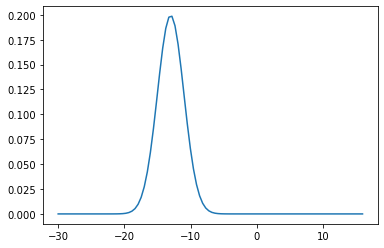

In [23]:
x = np.linspace(-30, 16, 100)
plt.plot(x, norm.pdf(x, loc = -13 , scale = 2))

In [24]:
norm.ppf([0.025, 0.975], loc = -13, scale = 2)

array([-16.91992797,  -9.08007203])

In this case the this is also the HDI as the distribution is symmetrical. 

I feel like i might be missing something here ;)

## Exercise 8.14
 
a) this is clearly a beta- binomial . 

b)  I think a Beta(2,2) is a good model here, as I think the country is currently pretty well deivided but dont have a lot of confidence in that.

c) The authors think this is more skewed toward lower pi. Ok fine.

mean:0.3333333333333333, var:0.05555555555555555, mode:0.0


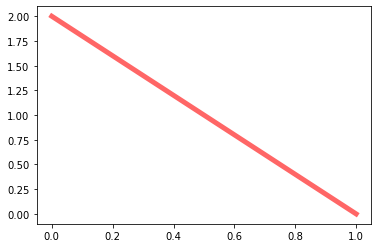

In [30]:
BetaBinomial.plotBeta(1,2)

d)  Import the data

In [32]:
pulse_data = pd.read_csv("pulse_data.csv")
pulse_data.head(5)

,Unnamed: 0,income,age,party,trump_approval,education,robots,climate_change,transformers,science_is_honest,vaccines_are_safe,books,ghosts,fed_sci_budget,earth_sun,wise_unwise
0,1,8,64,Democrat,Strongly disapprove,College degree,Unlikely,Real and Caused by People,1,Strongly Agree,Somewhat Disagree,20,Yes,Too Low,False,Wise but Unhappy
1,2,68,56,Democrat,Strongly disapprove,High school,Unlikely,Real and Caused by People,0,Somewhat Agree,Somewhat Disagree,6,No,Too High,False,Wise but Unhappy
2,3,46,63,Independent,Somewhat Approve,Some college,Unlikely,Real but not Caused by People,0,Somewhat Agree,Strongly Agree,0,No,About Right,True,Happy but Unwise
3,4,51,48,Republican,Strongly Approve,High school,Unlikely,Not Real At All,0,Somewhat Disagree,Somewhat Disagree,1,No,About Right,False,Happy but Unwise
4,5,100,32,Democrat,Somewhat Approve,Some college,Unlikely,Real and Caused by People,1,Strongly Agree,Strongly Agree,30,Yes,Too Low,False,Wise but Unhappy


In [35]:
n_obs = pulse_data.shape[0]
not_real = pulse_data[pulse_data['climate_change']== 'Not Real At All'].shape[0]

In [36]:
not_real/n_obs

0.15

So it looks like 15% of those surveyed said 'not real at all'.

In [37]:
BetaBinomial.summarize_beta_bin(1, 2, not_real, n_obs)

,alpha,beta,mean,mode,var,std
0,1,2,0.333333,0.00000,0.055556,0.235702
1,151,852,0.150548,0.14985,0.000127,0.011286


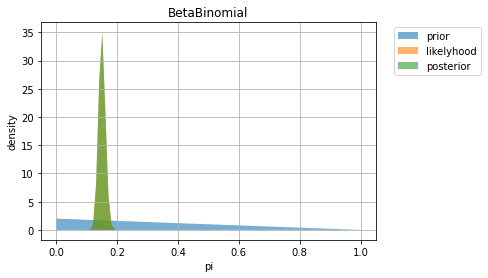

In [38]:
BetaBinomial.plotBetaBinomial(1,2,not_real, n_obs)

In [40]:
mci = beta.ppf([.025,.975],151,852)
mci

/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


array([0.12910004, 0.17331635])

## Exercise 8.15  

Suppose you wish to test a claim that more then 10% of the poeple believe in climate changeL  $(H_0: \pi <= .1$ vs $H_1: \pi >= .1)$

a) Using credible interval from previous exercise, i think this claim is well supported as 95% of probability lies above 0.13

b) Posterior prob:

In [43]:
post_prob= 1- beta.cdf(.1, 151, 852)
post_prob

0.9999996872502468

Very well supported. 
As for the bayes factor:

In [45]:
prior_prob = 1- beta.cdf(.1, 1, 2)
prior_prob

0.81

In [46]:
post_prob/(1-post_prob)*(1-prior_prob)/prior_prob

750017.6274121753

Based on this, I conclude that the hypothesis is true to a high degree of confidene.

## Exercise 8.16

Now we use MCMC.  We will create 4 chains, and check the autocorrelation and overlaid density plots. 
Also report effective sample size ration and R-hat. 


In [47]:
import stan
import arviz as az
import nest_asyncio
nest_asyncio.apply()

In [48]:
model = """data {
    int<lower=0, upper=1000> Y;
}
parameters {
    real<lower=0, upper =1> pi;
}

model {
    Y ~ binomial(1000, pi);
    pi ~ beta(1,2);
}"""

In [ ]:
posterior = stan.build(model, data={'Y':not_real})
fit = posterior.sample(num_chains=4, num_samples=10000)

array([[<AxesSubplot:title={'center':'pi'}>,
        <AxesSubplot:title={'center':'pi'}>]], dtype=object)

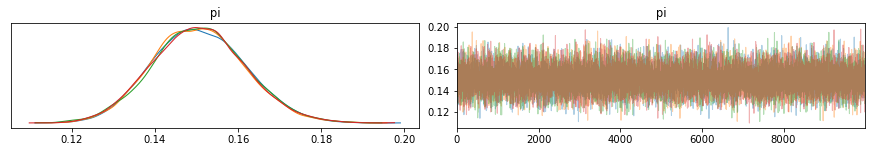

In [71]:
az.plot_trace(fit, compact = False)

In [72]:
az.summary(fit, var_names=['pi'],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi,0.151,0.011,0.129,0.172,0.0,0.0,15439.0,17351.0,1.0


array([<AxesSubplot:title={'center':'pi\n0'}>,
       <AxesSubplot:title={'center':'pi\n1'}>,
       <AxesSubplot:title={'center':'pi\n2'}>,
       <AxesSubplot:title={'center':'pi\n3'}>], dtype=object)

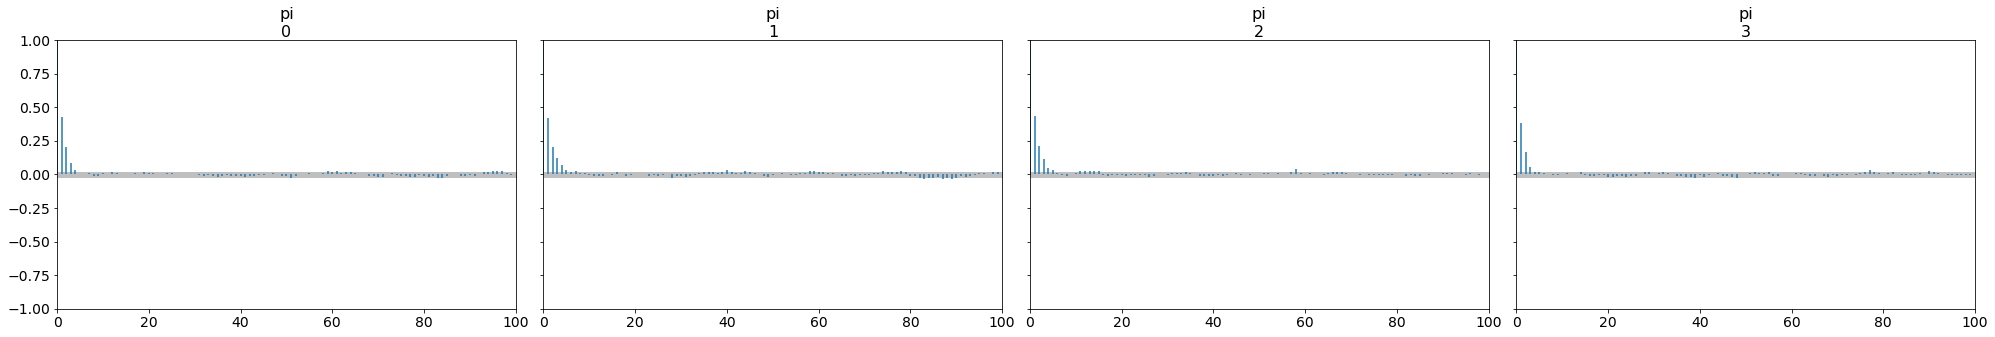

In [73]:
az.plot_autocorr(fit, var_names=['pi'])

## Exercise 8.17

In [128]:
dataset = az.convert_to_dataset(fit)
# There has to be a better way then this values.item nonsense!!

[dataset.quantile(q).pi.values.item() for q in [.025, .975]]

[0.12942384265498616, 0.17293348410064713]

A really good match to the analytical results!   Now lets do it directly using the chains

In [131]:
all_chains = dataset.pi.values.flatten()

In [139]:
np.quantile(all_chains, [.025,.975])

array([0.12942384, 0.17293348])

As for the hypothesis, every single sample is bigger then 0.1

In [138]:
all_chains[all_chains > 0.1].shape[0]

40000

MCMC is fully consistent with the analytical

## Exercise 8.18
I know that Arviz has built in posterior prediction but i will use manual method.

a) Suppose you were to survey 100 more adults, Construct a posterior predicitve samples of the result of this survey. 

b) summarize the posteriror predictive model

c) Estimate probability that at least 20 of the 100 people surveyed dont beleive in climate change.

In [156]:
post_prediction = binom.rvs(100,all_chains )

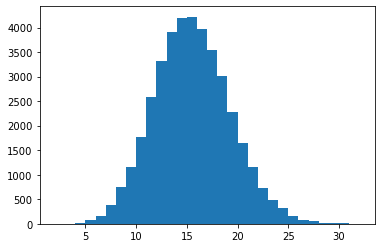

In [158]:
plt.hist(post_prediction, bins=30);

In [164]:
scipy.stats.describe(post_prediction)

DescribeResult(nobs=40000, minmax=(2, 32), mean=15.0292, variance=13.994047211180282, skewness=0.20723545565163715, kurtosis=0.03799429194006487)

In [165]:
np.quantile(post_prediction, [.025,.975])

array([ 8., 23.])

In [172]:
((post_prediction >= 20).sum())/post_prediction.shape[0]

0.117

I note that it is possible for *stan* to generate posterior predicited quantities (its a 'generated quantities' block.). I have not yet experimented with this. 